###  Sparse GP Regression- FITC prior for sampling over f.


This notebook uses the FITC prior to sample over the latent function values. The integration over inducing 
outputs(u) can be done analytically, and we can directly sample from the multivariate Gaussian. Data to be used will be Snelson 1D dataset.

In [1]:
%matplotlib inline
import  matplotlib
import matplotlib.pyplot as plt
import pystan

In [2]:
import numpy as np

In [3]:
import scipy.io as sio

In [4]:
df = sio.loadmat('snelson1d.mat')

In [5]:
X = df['X']
Y = df['Y']
X_t = df['tX']
Y_t = df['tY']

In [7]:
X_u = kmm_init(X)
M = len(X_u)

In [41]:
X_u_noisy = np.linspace(0,6, M)[:, None]
# X_u_noisy = X_u + 0.1*np.random.rand(*X_u.shape) 

### Code

In [46]:
stan_code_fitc_int ="""
data {
    int<lower=1> N;
    int<lower=1> M;
    real x[N];
    vector[N] y;
    real xu[M];

}
transformed data {
    real delta = 1e-6;
//     real rho = 0.9;
//     real alpha = 0.85;
//     real sigma = 0.12;
}

parameters {
    vector[N] f;
    
    real<lower=1e-6> sigma;
     real <lower=1e-6> alpha;
     real<lower=1e-6> rho;
    
    vector[M] eta2;
    
}

model {
    vector[N] f_mean;
    matrix[N, N] f_cov;
    matrix[N, N] S;
    matrix[N, N] A;
    matrix[N, N] A_inv;
    matrix [N,N] K_cov;
    matrix [N,N] Qff;
    matrix [N,N] L_fitc;
        
    {
        matrix[M, M] L_U;
        matrix[M, M] Kuu = cov_exp_quad(xu, alpha, rho);
        matrix[N, M] Kfu = cov_exp_quad(x, xu, alpha, rho);
        matrix[N, N] K = cov_exp_quad(x, alpha, rho);
        vector[M] Kuu_inv_u;
        matrix[M, N] v_pred;
        vector[M] u;
        
         for (m in 1:M)
             Kuu[m, m] = Kuu[m, m] + delta;
            
        L_U = cholesky_decompose(Kuu);
        u = L_U * eta2;
               
        Kuu_inv_u = mdivide_left_tri_low(L_U, eta2);
        f_mean = Kfu*Kuu_inv_u;
        

        // f_cov = K - Kfu*(Kuu_inv*Kfu');            
        v_pred = mdivide_left_tri_low(L_U, Kfu');
        
        Qff = v_pred'*v_pred;
        S = K - Qff;
        
        for (i in 1:N){
            for(j in 1:N){
                A[i,j] = 0.0;
                A_inv[i,j] = 0.0;
            }
            A[i,i] = S[i,i];
            A_inv[i,i] = 1./ S[i,i];
        }
        
        K_cov = A + Qff;
         
        L_fitc = cholesky_decompose(K_cov);
        
    }
  
#     rho ~ inv_gamma(5, 5);
#     alpha ~ normal(0, 1);

// strongly informative priors, but with these the covariance matrix will be more well behaved in my experience.
// The mean of the Gaussian priors is close to the optimised MAP value of the hyperparameters.

     rho ~ normal(0.90, 0.25);
     alpha ~ normal(0.85, 0.25);

    sigma ~ normal(0, 0.35);
    
    f ~ multi_normal(f_mean, K_cov);
    y ~ normal(f, sigma);
}

"""


In [47]:
stan_model_fitc = pystan.StanModel(model_code=stan_code_fitc_int)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2a1852564383d1375a07355b92c23c41 NOW.


In [48]:
gp_full_data2 = {'N':200, 'x':X.flatten(), 'y':Y.flatten(), 'M':20, 'xu':X_u_noisy.flatten()}

In [49]:
fit_fitc = stan_model_fitc.sampling(data=gp_full_data2, iter=800, chains=2)

/u/26/dhakaa1/unix/anaconda2/envs/stanpy35/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [50]:
print(fit_fitc)

Inference for Stan model: anon_model_2a1852564383d1375a07355b92c23c41.
2 chains, each with iter=800; warmup=400; thin=1; 
post-warmup draws per chain=400, total post-warmup draws=800.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
f[0]      -0.35    0.02   0.31  -0.91  -0.53  -0.41  -0.22   0.38    159   1.03
f[1]      -1.42    0.14   0.48  -2.06  -1.74  -1.56  -1.24  -0.14     11   1.24
f[2]       0.08    0.02   0.33  -0.59  -0.07    0.1   0.24   0.67    224   1.03
f[3]       0.12    0.02   0.32   -0.6  -0.03   0.13   0.28   0.78    361   1.02
f[4]      -0.89     0.1   0.38  -1.45  -1.13  -0.97  -0.74   0.09     14   1.19
f[5]        0.2    0.02    0.3  -0.44   0.07   0.24   0.37   0.75    324   1.02
f[6]       0.49    0.06   0.32  -0.29   0.35   0.53   0.67   1.06     28   1.07
f[7]      -0.33    0.02   0.33  -0.94   -0.5  -0.35  -0.19   0.42    290   1.02
f[8]       -0.2    0.02   0.29  -0.74  -0.36  -0.22  -0.05   0.44    283    1.0
f[9]       0.35

In [67]:
samples = fit_fitc.extract(permuted=True)
f = samples['f']
f_mean = np.mean(f, axis=0)
sigma = samples['sigma']
l = samples['rho']
sigvar = samples['alpha']
sigma_mean = np.mean(sigma, axis=0)

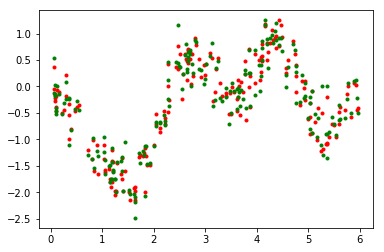

In [57]:
sort_idx = np.argsort(X.ravel())

plt.plot(X[sort_idx], Y[sort_idx], 'r.')
# plt.plot(X[sort_idx], f[-1, sort_idx], 'y.');
plt.plot(X[sort_idx], f[-100, sort_idx], 'g.');
# plt.plot(X[sort_idx], f_mean[sort_idx], 'b.');
# plt.plot(X[sort_idx], sigma[-1, sort_idx], 'b.');

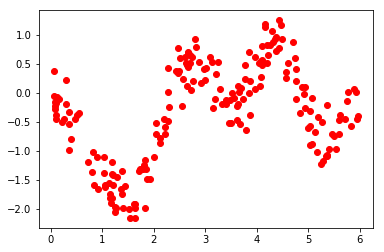

In [58]:
plt.plot(X,Y, 'ro')

(800, 20)


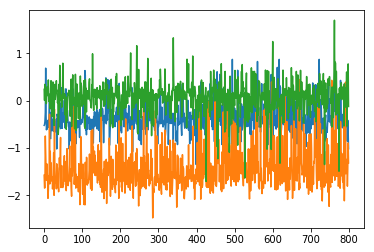

In [62]:
eta = samples['eta2']
print(eta.shape)
plt.plot(f[:, 0])
plt.plot(f[:, 1])
plt.plot(f[:, 2])


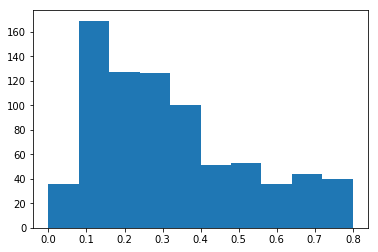

In [66]:
plt.hist(sigma, range=[0, 0.8]);

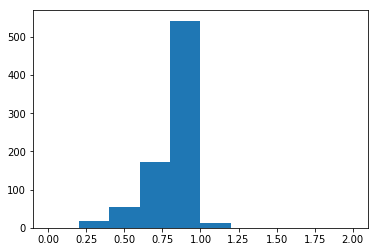

In [70]:
# plt.hist(l, range=[0, 2]);
plt.hist(sigvar, range=[0, 2]);

In [77]:
sigma_mean = np.mean(samples_fitc['sigma'])
sigma_median = np.nanmedian(samples_fitc['sigma'])

l_mean = np.mean(samples_fitc['rho'])
l_median = np.nanmedian(samples_fitc['rho'])

sigvar_mean = np.mean(samples_fitc['alpha'])
sigvar_median = np.nanmedian(samples_fitc['alpha'])

print("mean of noise variance: %.2f" % sigma_mean)
print("median of noise variance: %.2f"% sigma_median)
print("mean of lengthscale: %.3f"% l_mean)
print("median of lengthscale: %.3f"% l_median)
print("mean of signal variance: %.3f"% sigvar_mean)
print("median of signal variance: %.3f"% sigvar_median)

mean of noise variance: 0.33
median of noise variance: 0.29
mean of lengthscale: 0.000
median of lengthscale: 0.000
mean of signal variance: 0.817
median of signal variance: 0.856


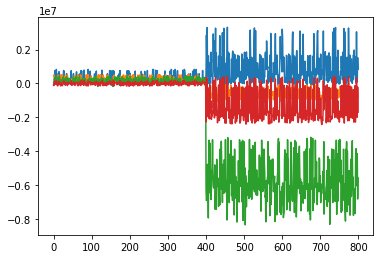

In [79]:
eta_fitc = samples_fitc['eta2']
plt.plot(eta_fitc[:, 0])
plt.plot(eta_fitc[:, 1])
plt.plot(eta_fitc[:, 2])
plt.plot(eta_fitc[:, 5])